In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os 
import osmnx as ox
import networkx as nx

In [3]:
# read csv into dataframe
df_all = pd.read_csv("df_all.csv")

In [4]:
# timestamps to datetime
df_all['iso_timestamp'] = pd.to_datetime(df_all['iso_timestamp'], utc=True, format='mixed')

# change columns to numerics
print(df_all.dtypes)
numeric_cols = [
    "channels_in", "channels_out", "channels_unknown", "channels_all", 
    "site_temperature", "site_rain_accumulation", "site_snow_accumulation"]

df_all[numeric_cols] = df_all[numeric_cols].apply(pd.to_numeric, errors='coerce')

df_all["count"] = df_all[["channels_out", "channels_in", "channels_unknown"]].fillna(0).sum(axis=1)


operator_name                          object
domain_name                            object
domain_id                               int64
counter_site                           object
counter_site_id                         int64
counter_serial                         object
longitude                             float64
latitude                              float64
timezone                               object
iso_timestamp             datetime64[ns, UTC]
channels_in                           float64
channels_out                          float64
channels_unknown                      float64
channels_all                            int64
site_temperature                      float64
site_rain_accumulation                float64
site_snow_accumulation                float64
dtype: object


In [5]:
# subset of dataframe just for one town 
df_domain = df_all[df_all["domain_name"] == "Stadt Freiburg"] # change domain name here for other towns
title_domain = df_domain["domain_name"].iloc[0]
print(title_domain)
df_domain_grouped = df_domain.groupby("counter_site")

# get coordinates for every counter site
domain_coords = {
    name: (
        df_domain_grouped.get_group(name)["latitude"].iloc[0],
        df_domain_grouped.get_group(name)["longitude"].iloc[0]
    )
    for name in df_domain_grouped.groups.keys()
}
domain_coords

Stadt Freiburg


{'FR1 Dreisam / Otto-Wels-Str.': (np.float64(47.99054), np.float64(7.8623013)),
 'FR2 Elsässer Str. / Uniklinik einzeln': (np.float64(48.007889),
  np.float64(7.835136)),
 'FR2 Güterbahn / Ferd.-Weiß-Str.': (np.float64(47.998592),
  np.float64(7.8220816)),
 'FR3 Eschholzstr. / Egonstr. einzeln': (np.float64(47.99984),
  np.float64(7.83717)),
 'FR6 Rotteckring / H Theater - Nord + Süd': (np.float64(47.99562128977538),
  np.float64(7.846155464631011)),
 'FR8 Schützenallee / Stadthalle': (np.float64(47.986279),
  np.float64(7.87144)),
 'H.-v.-Stephan-Str. 9 / JobRad - Ri. Nord': (np.float64(47.98803215116616),
  np.float64(7.836255293805153)),
 'H.-v.-Stephan-Str. 9 / JobRad - Ri. Süd': (np.float64(47.98808108339912),
  np.float64(7.835987434373238)),
 'Mundenhof 2 - Mundenhofer Str. - Waltershofen': (np.float64(48.0080292),
  np.float64(7.7802627)),
 'Wiwilibrücke': (np.float64(47.995213), np.float64(7.8407526))}

In [6]:
# we need a reference latitude for the conversion
lat0 = np.mean([coord[0] for coord in domain_coords.values()])

# function to convert lat/lon to x/y in meters
def latlon_to_xy(coord, lat0=lat0):
    lat, lon = coord
    R = 6371000 # radius of earth in meters
    x = R * np.radians(lon) * np.cos(np.radians(lat0))
    y = R * np.radians(lat)
    return np.array([x, y])

# distance matrix
sites1 = list(domain_coords.keys())
dist_matrix_euclid = pd.DataFrame(index=sites1, columns=sites1, dtype=float)

# compute euclidean distances and fill the distance matrix
for a in sites1:
    for b in sites1:
        p1 = latlon_to_xy(domain_coords[a])
        p2 = latlon_to_xy(domain_coords[b])
        dist_matrix_euclid.loc[a, b] = np.linalg.norm(p1 - p2)

dist_matrix_euclid

,FR1 Dreisam / Otto-Wels-Str.,FR2 Elsässer Str. / Uniklinik einzeln,FR2 Güterbahn / Ferd.-Weiß-Str.,FR3 Eschholzstr. / Egonstr. einzeln,FR6 Rotteckring / H Theater - Nord + Süd,FR8 Schützenallee / Stadthalle,H.-v.-Stephan-Str. 9 / JobRad - Ri. Nord,H.-v.-Stephan-Str. 9 / JobRad - Ri. Süd,Mundenhof 2 - Mundenhofer Str. - Waltershofen,Wiwilibrücke
FR1 Dreisam / Otto-Wels-Str.,0.000000,2794.179694,3123.806795,2136.904615,1327.640415,828.795549,1958.041565,1977.012017,6406.769273,1685.530284
FR2 Elsässer Str. / Uniklinik einzeln,2794.179694,0.000000,1418.546351,907.714736,1591.577659,3615.451173,2209.551107,2203.450839,4083.150315,1470.161903
FR2 Güterbahn / Ferd.-Weiß-Str.,3123.806795,1418.546351,0.000000,1131.271067,1821.537668,3919.655216,1578.311071,1560.984661,3283.918335,1439.218354
FR3 Eschholzstr. / Egonstr. einzeln,2136.904615,907.714736,1131.271067,0.000000,816.756320,2962.508565,1314.735868,1310.489470,4331.273211,579.460660
FR6 Rotteckring / H Theater - Nord + Süd,1327.640415,1591.577659,1821.537668,816.756320,0.000000,2149.158885,1120.181949,1129.343706,5093.500016,404.582301
FR8 Schützenallee / Stadthalle,828.795549,3615.451173,3919.655216,2962.508565,2149.158885,0.000000,2625.340477,2645.623825,7202.682902,2490.182982
H.-v.-Stephan-Str. 9 / JobRad - Ri. Nord,1958.041565,2209.551107,1578.311071,1314.735868,1120.181949,2625.340477,0.000000,20.660732,4722.627864,865.764141
H.-v.-Stephan-Str. 9 / JobRad - Ri. Süd,1977.012017,2203.450839,1560.984661,1310.489470,1129.343706,2645.623825,20.660732,0.000000,4702.484353,868.691698
Mundenhof 2 - Mundenhofer Str. - Waltershofen,6406.769273,4083.150315,3283.918335,4331.273211,5093.500016,7202.682902,4722.627864,4702.484353,0.000000,4721.267328
Wiwilibrücke,1685.530284,1470.161903,1439.218354,579.460660,404.582301,2490.182982,865.764141,868.691698,4721.267328,0.000000


In [7]:
# compute median of lats and lons for center point
lats = [coord[0] for coord in domain_coords.values()]
cp_lat = np.median(lats)

lons = [coord[1] for coord in domain_coords.values()]
cp_lon = np.median(lons)

# set median as center point 
center_point = (cp_lat, cp_lon)  

# access streetmaps graph with bike lanes, with median cp and 6km radius (adjust if needed)
G = ox.graph_from_point(center_point, dist=6000, network_type='bike')

In [8]:
# nodes in our graph are our counter sites 
snapped_nodes = {}
for name, (lat, lon) in domain_coords.items():
    node = ox.distance.nearest_nodes(G, X=lon, Y=lat)
    snapped_nodes[name] = node

In [9]:
# now name the nodes and compute shortest distance by bike
distances1 = {}
for i in snapped_nodes:
    for j in snapped_nodes:
        if (j, i) in distances1:
            distances1[(i, j)] = distances1[(j, i)]
            continue
        if i == j:
            distances1[(i, j)] = 0
            continue
        d = nx.shortest_path_length(G, snapped_nodes[i], snapped_nodes[j], weight='length')
        distances1[(i, j)] = d
        print(f"distance between {i} and {j}: {d:.1f} m")


distance between FR1 Dreisam / Otto-Wels-Str. and FR2 Elsässer Str. / Uniklinik einzeln: 3490.9 m
distance between FR1 Dreisam / Otto-Wels-Str. and FR2 Güterbahn / Ferd.-Weiß-Str.: 3482.8 m
distance between FR1 Dreisam / Otto-Wels-Str. and FR3 Eschholzstr. / Egonstr. einzeln: 2796.6 m
distance between FR1 Dreisam / Otto-Wels-Str. and FR6 Rotteckring / H Theater - Nord + Süd: 1910.1 m
distance between FR1 Dreisam / Otto-Wels-Str. and FR8 Schützenallee / Stadthalle: 1217.3 m
distance between FR1 Dreisam / Otto-Wels-Str. and H.-v.-Stephan-Str. 9 / JobRad - Ri. Nord: 2130.8 m
distance between FR1 Dreisam / Otto-Wels-Str. and H.-v.-Stephan-Str. 9 / JobRad - Ri. Süd: 2142.5 m
distance between FR1 Dreisam / Otto-Wels-Str. and Mundenhof 2 - Mundenhofer Str. - Waltershofen: 6941.3 m
distance between FR1 Dreisam / Otto-Wels-Str. and Wiwilibrücke: 2001.7 m
distance between FR2 Elsässer Str. / Uniklinik einzeln and FR2 Güterbahn / Ferd.-Weiß-Str.: 1433.8 m
distance between FR2 Elsässer Str. / Unik

In [10]:
# compute all the routes as well and store them in a dict
# you can plot it too! (uncomment last line, do not recommend it for towns with many sites though)
routes = {}

keys = list(snapped_nodes.keys())

for i in keys:
    for j in keys:
        if (j, i) in routes:
            routes[(i, j)] = routes[(j, i)]
            continue
        if i == j:
            routes[(i, j)] = [snapped_nodes[i]]
            continue
        r = nx.shortest_path(G, snapped_nodes[i], snapped_nodes[j], weight='length')
        routes[(i, j)] = r
        #ox.plot_graph_route(G, r)



- Heidelberg: 15 counter
- Stuttgart: 15 counter
- Ludwigsburg: 15 counter
- Stadt Mannheim: 14 counter
- Stadt Freiburg: 10 counter
- Stadt Reutlingen: 7 counter
- Ravensburg Tws Gmbh & Co. Kg: 7 counter
- Stadt Konstanz: 6 counter
- Tübingen: 5 counter
- Heilbronn: 4 counter
- Lörrach: 2 counter


In [11]:
# pivot table for correlation matrix
df_domain_pivot = df_domain.pivot_table(
    index = 'iso_timestamp',
    columns = 'counter_site',
    values = 'count',
    aggfunc='sum'
)

# we want to see how many timestamps have data for both sites
mask = df_domain_pivot.notna().astype(int)
overlap = mask.T.dot(mask)
overlap

counter_site,FR1 Dreisam / Otto-Wels-Str.,FR2 Elsässer Str. / Uniklinik einzeln,FR2 Güterbahn / Ferd.-Weiß-Str.,FR3 Eschholzstr. / Egonstr. einzeln,FR6 Rotteckring / H Theater - Nord + Süd,FR8 Schützenallee / Stadthalle,H.-v.-Stephan-Str. 9 / JobRad - Ri. Nord,H.-v.-Stephan-Str. 9 / JobRad - Ri. Süd,Mundenhof 2 - Mundenhofer Str. - Waltershofen,Wiwilibrücke
counter_site,,,,,,,,,,
FR1 Dreisam / Otto-Wels-Str.,91934,6087,91916,88583,6087,6087,6087,6087,14263,91914
FR2 Elsässer Str. / Uniklinik einzeln,6087,12622,12593,12591,12622,12622,12622,12607,12622,12589
FR2 Güterbahn / Ferd.-Weiß-Str.,91916,12593,98458,95124,12593,12593,12593,12589,20769,98454
FR3 Eschholzstr. / Egonstr. einzeln,88583,12591,95124,95124,12591,12591,12591,12588,20767,95122
FR6 Rotteckring / H Theater - Nord + Süd,6087,12622,12593,12591,12629,12629,12629,12607,12629,12589
FR8 Schützenallee / Stadthalle,6087,12622,12593,12591,12629,12629,12629,12607,12629,12589
H.-v.-Stephan-Str. 9 / JobRad - Ri. Nord,6087,12622,12593,12591,12629,12629,12629,12607,12629,12589
H.-v.-Stephan-Str. 9 / JobRad - Ri. Süd,6087,12607,12589,12588,12607,12607,12607,12607,12607,12587
Mundenhof 2 - Mundenhofer Str. - Waltershofen,14263,12622,20769,20767,12629,12629,12629,12607,20805,20765


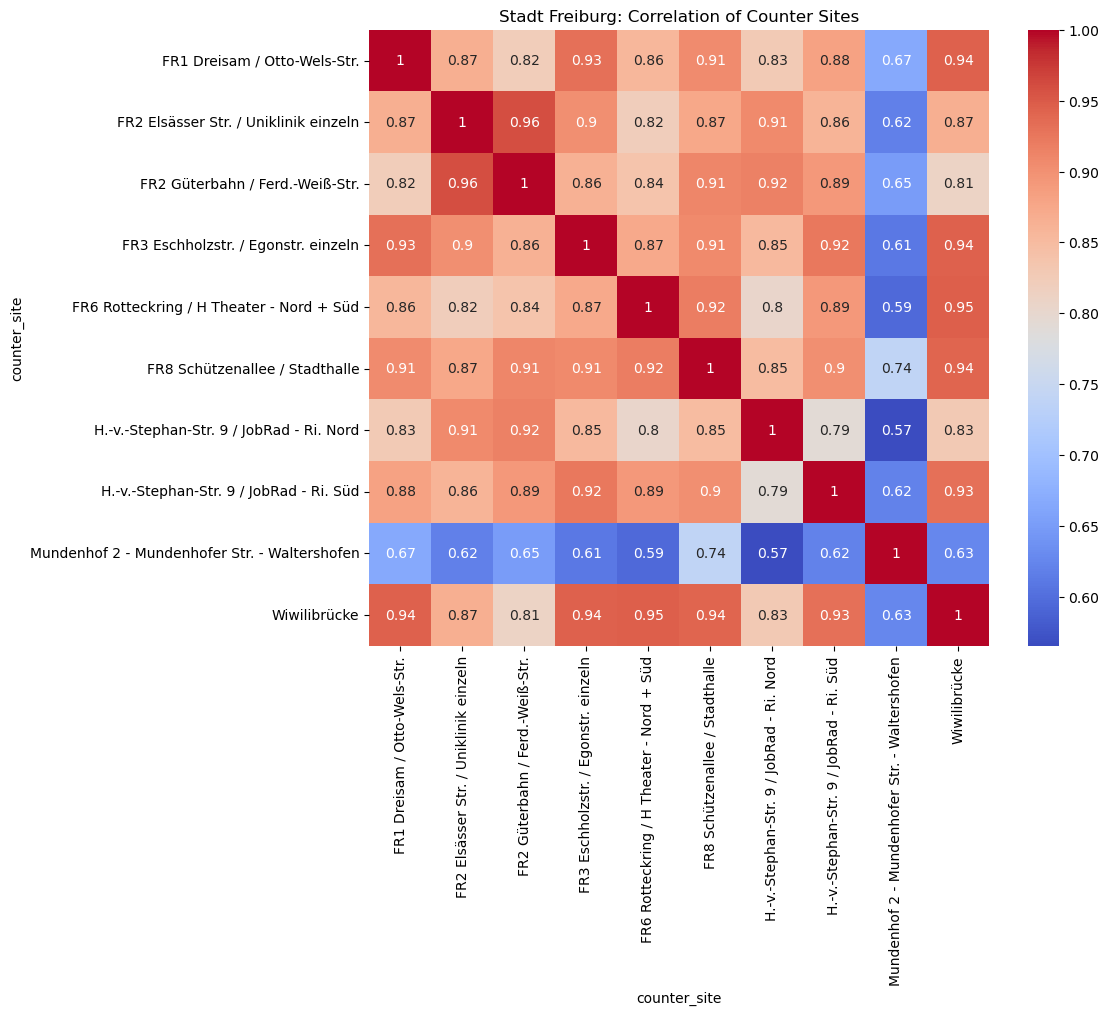

In [12]:
# compute correlation matrix and plot heatmap
# this shows correlation of counter sites based on their counts
corr_matrix = df_domain_pivot.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title(f"{title_domain}: Correlation of Counter Sites")
plt.show()

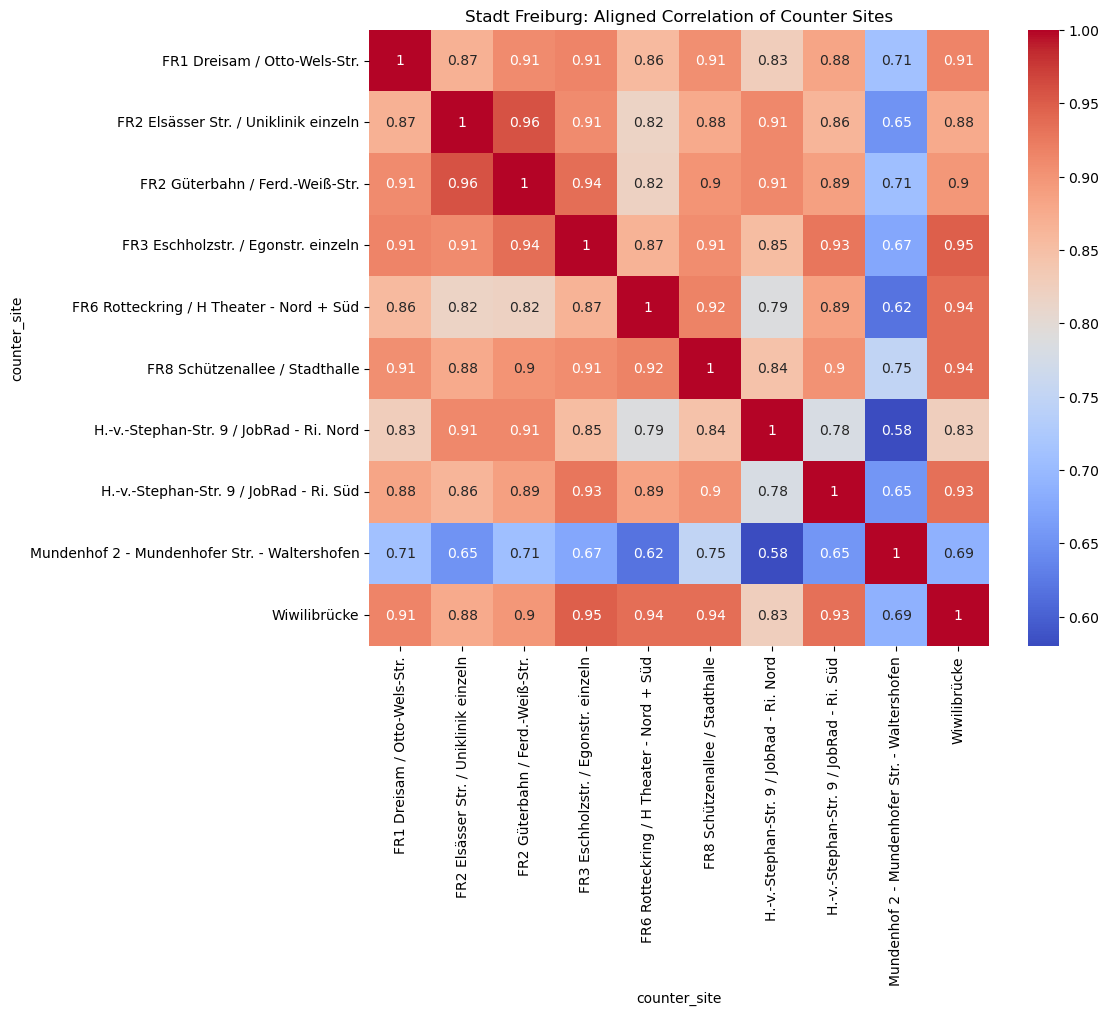

In [13]:
# correlation matrix for just times where all sites have data
# maybe more meaningful, still not sure
aligned = df_domain_pivot.dropna()
corr_matrix1 = aligned.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix1, annot=True, cmap='coolwarm')
plt.title(f"{title_domain}: Aligned Correlation of Counter Sites")
plt.show()

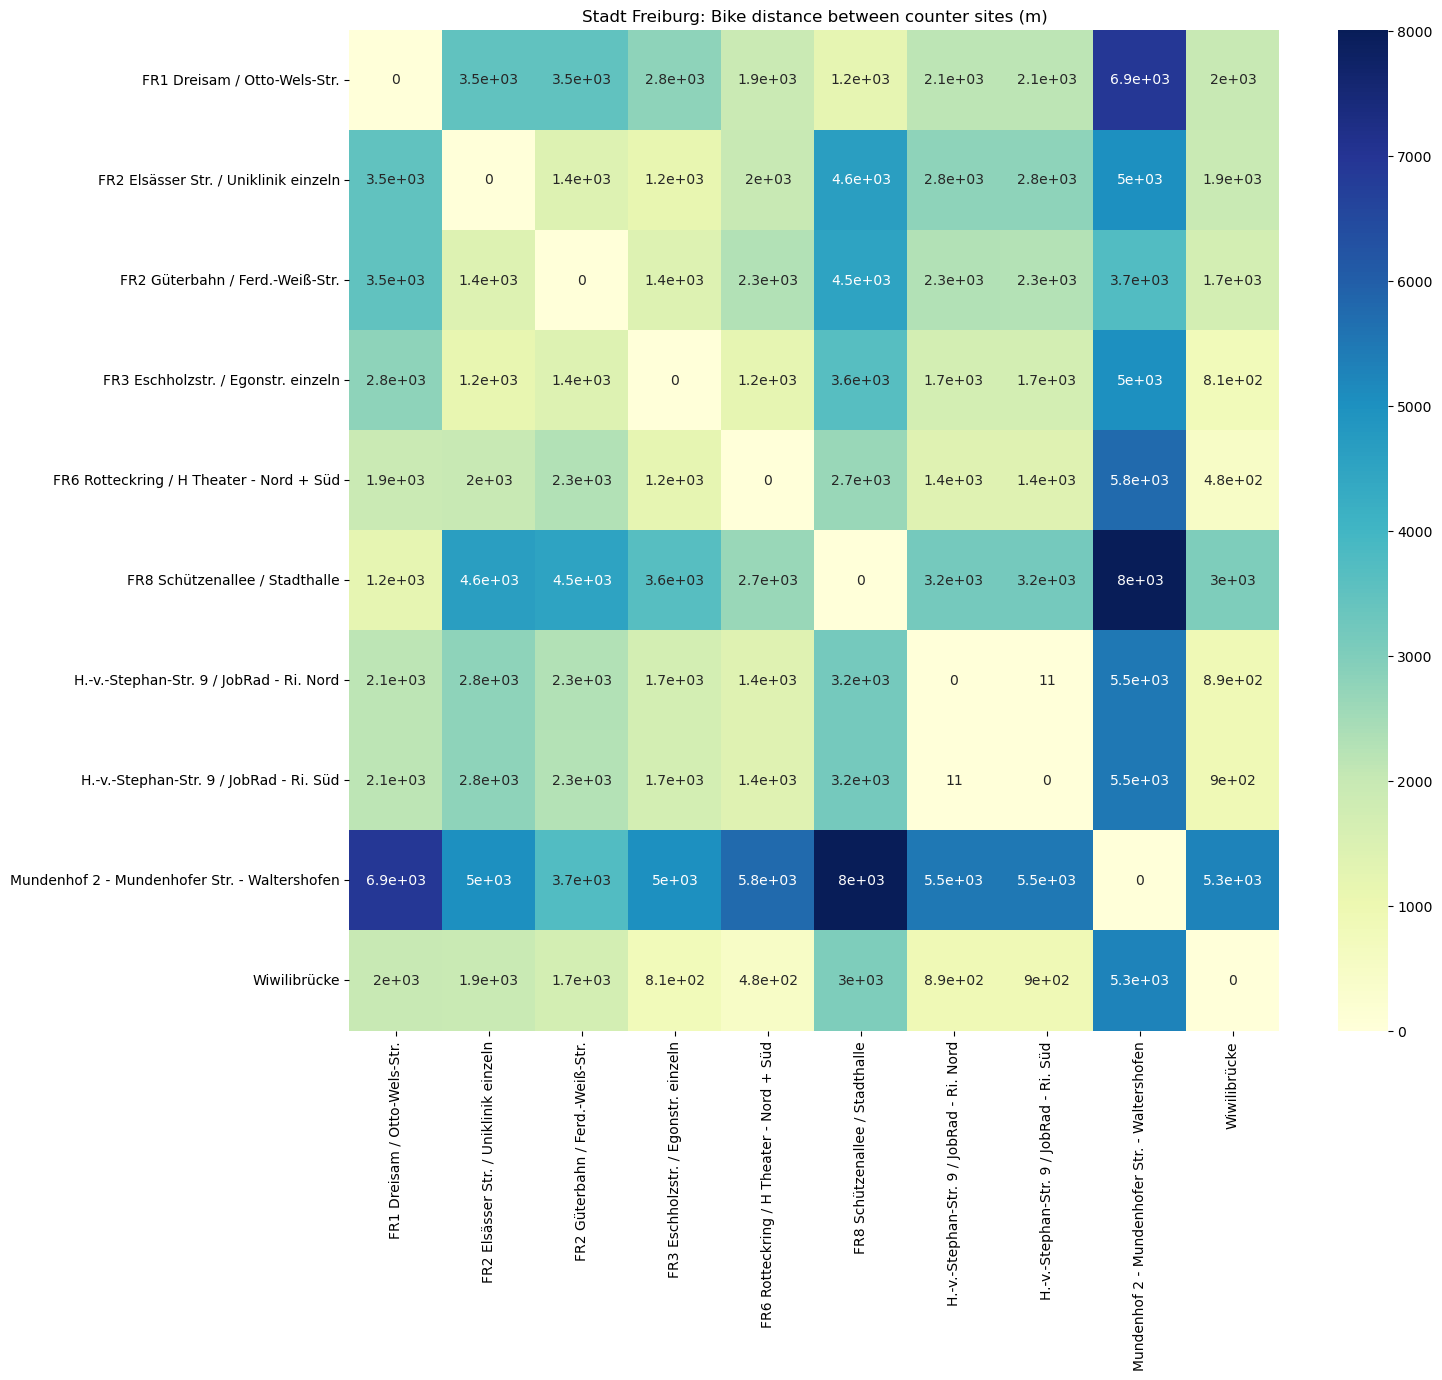

In [14]:
# now we want matrices for distances
# create distance matrix (for bike dist)
dist_matrix = pd.DataFrame(index=sites1, columns=sites1)
for (site1, site2), dist in distances1.items():
    dist_matrix.loc[site1, site2] = dist
    dist_matrix.loc[site2, site1] = dist

# fill diagonal with 0
dist_matrix.fillna(0, inplace=True)

# check shape
dist_matrix.shape

# heatmap for distances 
plt.figure(figsize=(15,13))
sns.heatmap(dist_matrix.astype(int), annot=True, cmap='YlGnBu')
plt.title(f"{title_domain}: Bike distance between counter sites (m)")
plt.show()  

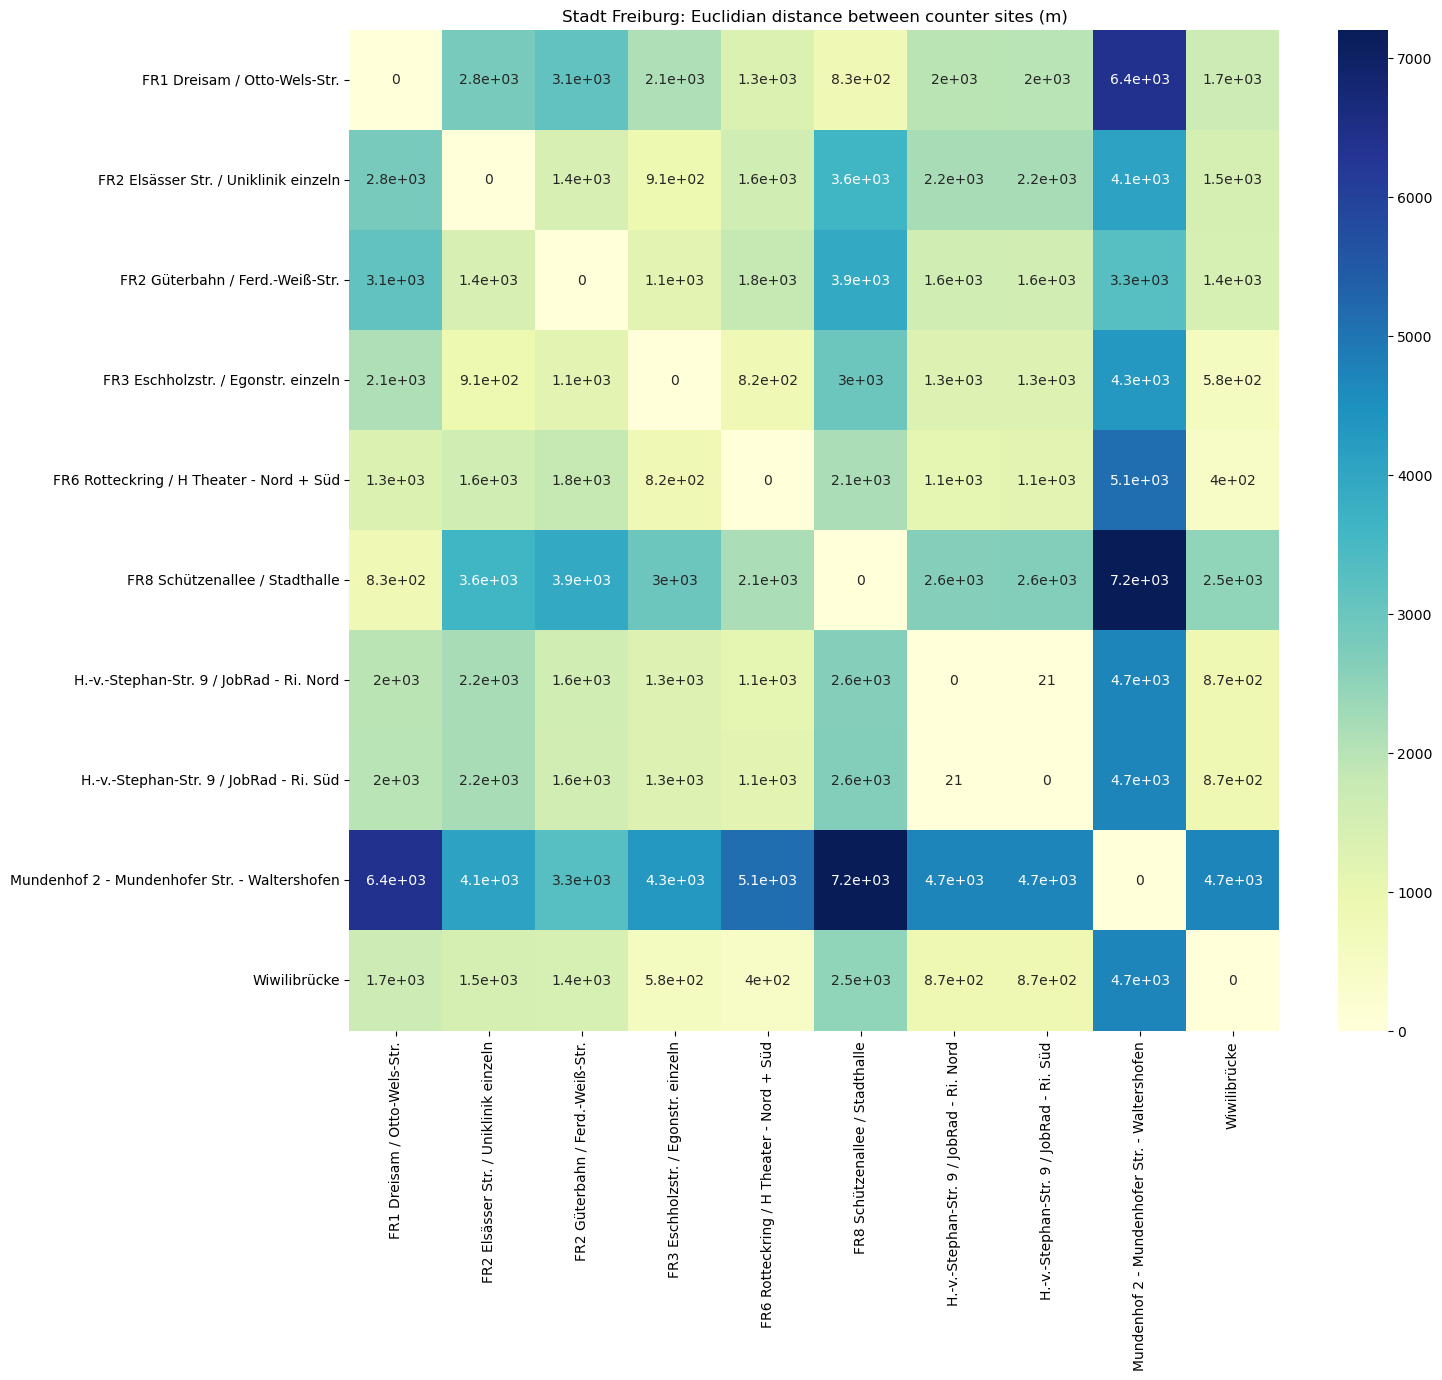

In [15]:
# now again for euclidian distances (we computed matrix already above)
plt.figure(figsize=(15,13))
sns.heatmap(dist_matrix_euclid.astype(float), annot=True, cmap='YlGnBu')
plt.title(f"{title_domain}: Euclidian distance between counter sites (m)")
plt.show()

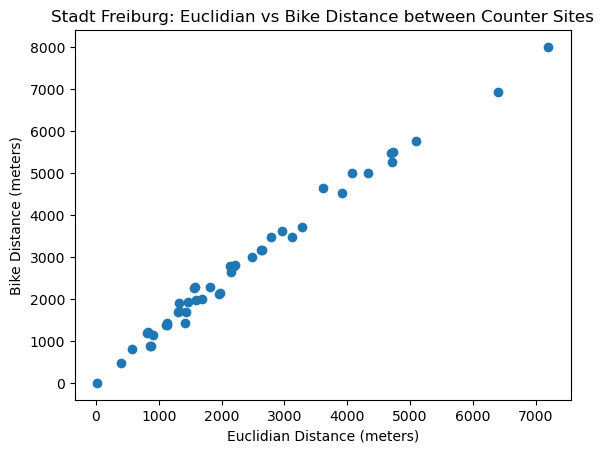

In [16]:
# euclidian vs bike distance scatter plot
euclidian_distances = []
bike_distances = []
for site_a in sites1:
    for site_b in sites1:
        if site_a >= site_b:
            continue
        euclidian_distances.append(dist_matrix_euclid.loc[site_a, site_b])
        bike_distances.append(dist_matrix.loc[site_a, site_b])
plt.scatter(euclidian_distances, bike_distances)
plt.xlabel("Euclidian Distance (meters)")
plt.ylabel("Bike Distance (meters)")
plt.title(f"{title_domain}: Euclidian vs Bike Distance between Counter Sites")
plt.show()

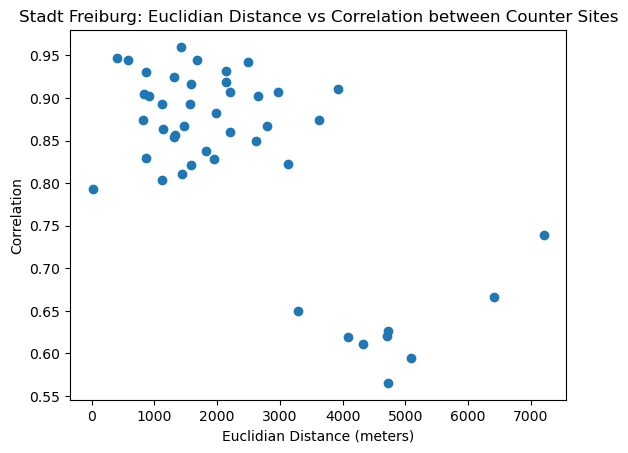

In [17]:
# euclidian distance vs correlation plot
# using euclidian distance and unaligned correlation
correlations = []
distance_values = []
for i in range(len(sites1)):
    for j in range(i + 1, len(sites1)):
        site1 = sites1[i]
        site2 = sites1[j]
        distance = dist_matrix_euclid.loc[site1, site2]
        correlation = corr_matrix.loc[site1, site2]
        distance_values.append(distance)
        correlations.append(correlation)

plt.scatter(distance_values, correlations)
plt.xlabel("Euclidian Distance (meters)")
plt.ylabel("Correlation")
plt.title(f"{title_domain}: Euclidian Distance vs Correlation between Counter Sites")
plt.show()

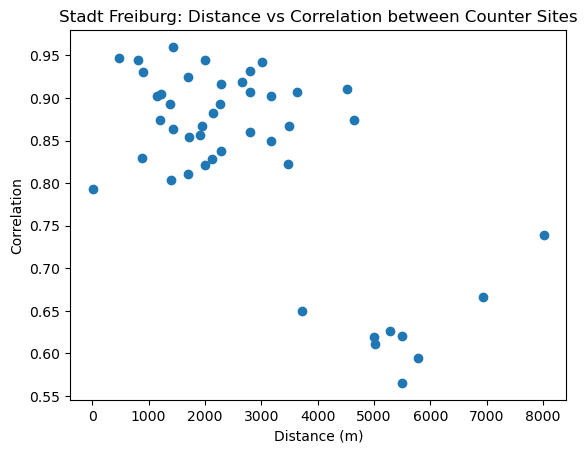

In [18]:
# distance vs correlation plot
# using bike distance and unaligned correlation
correlations = []
distance_values = []
for i in range(len(sites1)):
    for j in range(i + 1, len(sites1)):
        site1 = sites1[i]
        site2 = sites1[j]
        distance = dist_matrix.loc[site1, site2]
        correlation = corr_matrix.loc[site1, site2]
        distance_values.append(distance)
        correlations.append(correlation)


plt.scatter(distance_values, correlations)
plt.xlabel("Distance (m)")
plt.ylabel("Correlation")
plt.title(f"{title_domain}: Distance vs Correlation between Counter Sites")
plt.show()

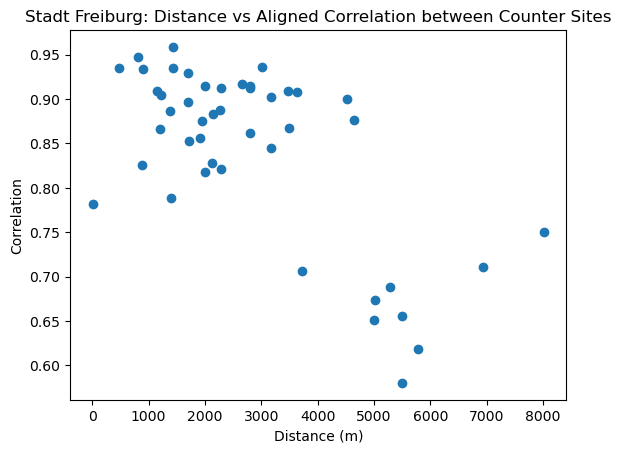

In [19]:
# distance vs correlation plot
# using bike distance and aligned correlation
correlations = []
distance_values = []
for i in range(len(sites1)):
    for j in range(i + 1, len(sites1)):
        site1 = sites1[i]
        site2 = sites1[j]
        distance = dist_matrix.loc[site1, site2]
        correlation = corr_matrix1.loc[site1, site2]
        distance_values.append(distance)
        correlations.append(correlation)


plt.scatter(distance_values, correlations)
plt.xlabel("Distance (m)")
plt.ylabel("Correlation")
plt.title(f"{title_domain}: Distance vs Aligned Correlation between Counter Sites")
plt.show()

In [ ]:
################################################
# REGRESSION MODELING - SETUP                  #
################################################

import importlib
import regression_utils
importlib.reload(regression_utils)

from regression_utils import train_model

# Load city data with features
df_city = pd.read_csv('df_features.csv')
df_city = df_city[df_city['domain_name'] == title_domain].copy()

print(f"✓ Loaded {len(df_city):,} hourly records for {title_domain}")
print(f"✓ {df_city['counter_site'].nunique()} stations")
print(f"✓ regression_utils.py reloaded")

✓ Loaded 481,718 hourly records for Stadt Freiburg
✓ 10 stations


In [45]:
################################################
# TRAIN MODELS FOR ALL STATIONS               #
################################################

all_results = []

for station_idx, station in enumerate(sites1, 1):
    print(f"\n[{station_idx}/{len(sites1)}] {station}")
    
    # Get station data
    df_station = df_city[df_city['counter_site'] == station].copy()
    df_station = df_station.dropna(subset=['channels_all'])
    df_station = df_station.sort_values('iso_timestamp')
    
    # Skip if insufficient data
    if len(df_station) < 1000:
        print(f"    ⊗ Skipped - only {len(df_station)} records")
        continue
    
    print(f"    Data: {len(df_station):,} hourly records")
    
    # Train model
    results, model, features = train_model(df_station, station, df_city)
    
    # Format feature names
    temporal_str = ', '.join(results['temporal_features'])
    weather_str = ', '.join(results['weather_features']) if results['weather_features'] else 'none'
    
    all_results.append(results)
    
    print(f"    Features: {temporal_str} + {weather_str} + {results['n_stations']} station counts = {results['n_features']} total")
    print(f"    Test R² = {results['test_r2']:.4f} | RMSE = {results['test_rmse']:.2f}")

# Create summary DataFrame
results_df = pd.DataFrame(all_results)

print(f"\n{'='*70}")
print(f"SUMMARY - {title_domain}")
print(f"{'='*70}")
print(f"\nAverage Test R²:   {results_df['test_r2'].mean():.4f} ± {results_df['test_r2'].std():.4f}")
print(f"Average Test RMSE: {results_df['test_rmse'].mean():.2f} ± {results_df['test_rmse'].std():.2f}")
print(f"Average Test MAE:  {results_df['test_mae'].mean():.2f} ± {results_df['test_mae'].std():.2f}")

# Print results as markdown table
print(f"\n## Results Table\n")
print("| Station | Test R² | RMSE | MAE | Features |")
print("|---------|---------|------|-----|----------|")
for _, row in results_df.iterrows():
    print(f"| {row['station'][:30]} | {row['test_r2']:.4f} | {row['test_rmse']:.2f} | {row['test_mae']:.2f} | {row['n_features']} |")

# Save results
results_df.to_csv(f'regression_results_{title_domain.replace(" ", "_")}.csv', index=False)
print(f"\n✓ Saved: regression_results_{title_domain.replace(' ', '_')}.csv")


[1/10] FR1 Dreisam / Otto-Wels-Str.
    Data: 91,934 hourly records


KeyError: 'temporal_features'